# Введение в анализ данных

# Семинар 10.

## Градиентный бустинг и случайные леса

Сравним поведение двух методов построения композиции алгоритмов над деревьями на примере задачи [Kaggle: Predicting a Biological Response](https://www.kaggle.com/c/bioresponse):

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

data = pd.read_csv('./train.csv')
X = data.iloc[:, 1:].values
y = data.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=241)

In [3]:
%%time
gbm = GradientBoostingClassifier(n_estimators=250, learning_rate=0.2, verbose=True).fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           1.2613           15.18s
         2           1.1713           13.61s
         3           1.1007           12.99s
         4           1.0524           12.78s
         5           1.0125           12.53s
         6           0.9736           12.35s
         7           0.9441           12.22s
         8           0.9194           11.55s
         9           0.8950           11.48s
        10           0.8786           11.05s
        20           0.7166            9.67s
        30           0.5979            8.95s
        40           0.5150            8.34s
        50           0.4578            7.87s
        60           0.3984            7.53s
        70           0.3420            7.18s
        80           0.3078            6.71s
        90           0.2588            6.28s
       100           0.2241            5.82s
       200           0.0767            1.83s
CPU times: user 9.03 s, sys: 35.6 ms, total: 9.06 s
Wa

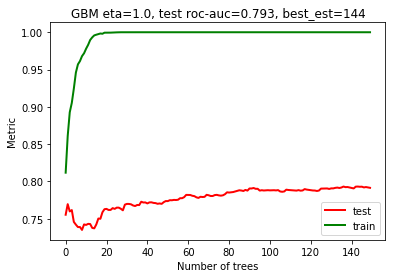

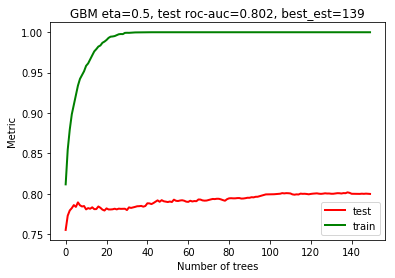

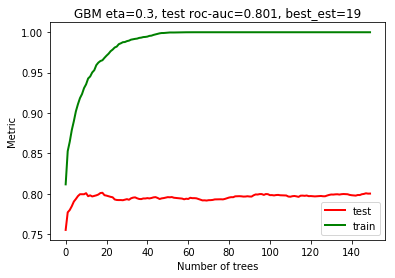

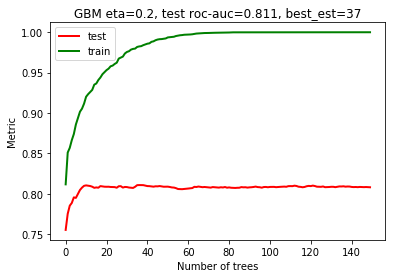

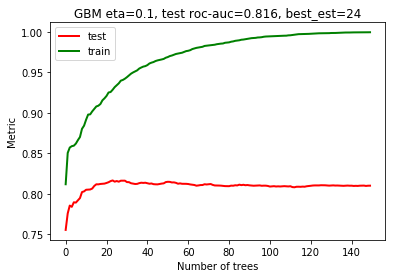

In [6]:
import numpy as np
from sklearn.metrics import roc_auc_score

for learning_rate in [1, 0.5, 0.3, 0.2, 0.1]:

    gbm = GradientBoostingClassifier(n_estimators=150, learning_rate=learning_rate, random_state=241).fit(X_train, y_train)
    
    l = roc_auc_score

    test_deviance = np.zeros((gbm.n_estimators,), dtype=np.float64)
    for i, y_pred in enumerate(gbm.staged_decision_function(X_test)):
        y_pred = 1.0 / (1.0 + np.exp(-y_pred))
        test_deviance[i] = roc_auc_score(y_test, y_pred)
    
    train_deviance = np.zeros((gbm.n_estimators,), dtype=np.float64)
    for i, y_pred in enumerate(gbm.staged_decision_function(X_train)):
        y_pred = 1.0 / (1.0 + np.exp(-y_pred))
        train_deviance[i] = roc_auc_score(y_train, y_pred)

    plt.figure()
    plt.plot(test_deviance, 'r', linewidth=2)
    plt.plot(train_deviance, 'g', linewidth=2)
    plt.legend(['test', 'train'])
    
    plt.title('GBM eta=%.1f, test roc-auc=%.3f, best_est=%d' % (learning_rate, test_deviance.max(), test_deviance.argmax()+1))
    plt.xlabel('Number of trees')
    plt.ylabel('Metric')

Итого, лучшая композиция построена при $\eta = 0.1$, включает 24 базовых алгоритма и достигает значения 0.816 на контрольной выборке. При этом случайный лес с таким же количеством базовых алгоритмов уступает градиентному бустингу:

In [9]:
rf = RandomForestClassifier(n_estimators=24, random_state=241).fit(X_train, y_train)
print ('Train RF ROC-AUC =', roc_auc_score(y_train, rf.predict_proba(X_train)[:,1]))
print ('Test RF ROC-AUC = ', roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))

Train RF ROC-AUC = 0.999985765529807
Test RF ROC-AUC =  0.7966916829914107


Заметим также, что при всём этом случайный лес, в отличие от градиентного бустинга, использует глубокие деревья, требующие вычислительных мощностей для их обучения.

Для достижения такого же качества случайному лесу требуется гораздо большее число базовых алгоритмов:

In [10]:
for n_estimators in range(10, 101, 10):
    rf = RandomForestClassifier(n_estimators=n_estimators, n_jobs=4).fit(X_train, y_train)
    print(n_estimators, 'trees: train ROC-AUC =',  roc_auc_score(y_train, rf.predict_proba(X_train)[:,1]), 'test ROC-AUC =',  roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))

10 trees: train ROC-AUC = 0.9992277799920287 test ROC-AUC = 0.7898969567806886
20 trees: train ROC-AUC = 1.0 test ROC-AUC = 0.7934004979943886
30 trees: train ROC-AUC = 1.0 test ROC-AUC = 0.8081943487682892
40 trees: train ROC-AUC = 1.0 test ROC-AUC = 0.8181892181344583
50 trees: train ROC-AUC = 1.0 test ROC-AUC = 0.8140757414304064
60 trees: train ROC-AUC = 1.0 test ROC-AUC = 0.8235815411993486
70 trees: train ROC-AUC = 1.0 test ROC-AUC = 0.820959267072812
80 trees: train ROC-AUC = 1.0 test ROC-AUC = 0.8218216979168909
90 trees: train ROC-AUC = 1.0 test ROC-AUC = 0.8171729579718569
100 trees: train ROC-AUC = 1.0 test ROC-AUC = 0.8265722432709764


## Современные библиотеки

Ранее мы использовали наивную версию градиентного бустинга из scikit-learn, [придуманную](https://projecteuclid.org/download/pdf_1/euclid.aos/1013203451) в 1999 году Фридманом. С тех пор было предложено много реализаций, которые оказываются лучше на практике. На сегодняшний день популярны три библиотеки, реализующие градиентный бустинг:
* XGBoost. После выхода быстро набрала популярность и оставалась стандартом до конца 2016 года. Об особенностях данной библиотеки рассказывалось на лекции.
* LightGBM. Отличительной чертой является быстрота построения композиции. Например, используется следующий трюк для ускорения обучения: при построении вершины дерева вместо перебора по всем значениям признака производится перебор значений гистограммы этого признака. Таким образом, вместо $O(\ell)$ требуется $O$(#bins). Кроме того, в отличие от других библиотек, которые строят дерево по уровням, LightGBM использует стратегию best-first, т.е. на каждом шаге строит вершину, дающую наибольшее уменьшение функционала. Поэтому ограничение на num_leaves получается более осмысленным.
* CatBoost. Библиотека от компании Яндекс. Позволяет автоматически обрабатывать категориальные признаки. Кроме того, алгоритм является менее чувствительным к выбору конкретных гиперпараметров. За счёт этого уменьшается время, которое тратит человек на подбор оптимальных гиперпараметров.

### Основные параметры
* objective – функционал, на который будет настраиваться композиция
* eta / learning_rate – темп (скорость) обучения
* num_iterations / n_estimators  – число итераций бустинга

#### Параметры, отвечающие за сложность деревьев
* max_depth – максимальная глубина 
* max_leaves / num_leaves – максимальное число вершин в дереве
* gamma / min_gain_to_split – порог на уменьшение функции ошибки при расщеплении в дереве
* min_data_in_leaf – минимальное число объектов в листе
* min_sum_hessian_in_leaf – минимальная сумма весов объектов в листе, минимальное число объектов, при котором делается расщепление 
* lambda – коэффициент регуляризации (L2)
* subsample / bagging_fraction – какую часть объектов обучения использовать для построения одного дерева 
* colsample_bytree / feature_fraction – какую часть признаков использовать для построения одного дерева 

Подбор всех этих параметров — настоящее искусство. Но начать их настройку можно с самых главных параметров: learning_rate и n_estimators. Обычно один из них фиксируют, а оставшийся из этих двух параметров подбирают (например, фиксируют n_estimators=1000 и подбирают learning_rate). Следующим по важности является max_depth. В силу того, что мы заинтересованы в неглубоких деревьях, обычно его перебирают из диапазона [3; 7].




In [11]:
from sklearn.datasets import make_classification
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

def plot_surface(X, y, clf):
    h = 0.2
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(8, 8))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

X, y = make_classification(n_samples=500, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0,
                           n_classes=2, n_clusters_per_class=2,
                           flip_y=0.05, class_sep=0.8, random_state=241)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=241)

## Catboost

0.9132290184921764


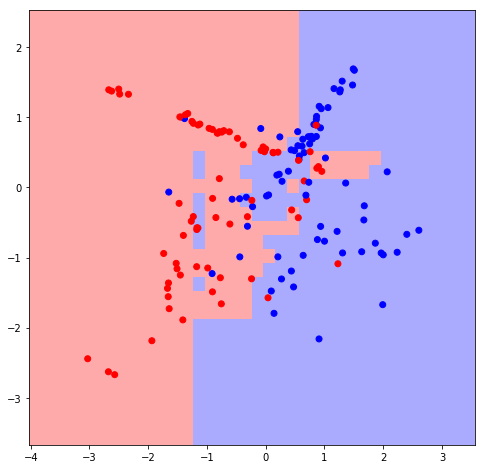

In [12]:
from catboost import CatBoostClassifier 

clf = CatBoostClassifier(iterations=300, logging_level='Silent')
clf.fit(X_train, y_train)
plot_surface(X_test, y_test, clf)

print(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

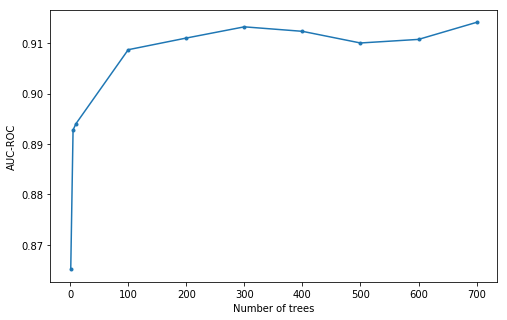

In [13]:
n_trees = [1, 5, 10, 100, 200, 300, 400, 500, 600, 700]
quals = []
for n in n_trees:
    clf = CatBoostClassifier(iterations=n, logging_level='Silent')
    clf.fit(X_train, y_train)
    q = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    quals.append(q)
    
plt.figure(figsize=(8, 5))
plt.plot(n_trees, quals, marker='.')
plt.xlabel('Number of trees')
plt.ylabel('AUC-ROC')
plt.show()

## LightGBM

0.8629089615931721


/Users/vkokhtev/programs/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


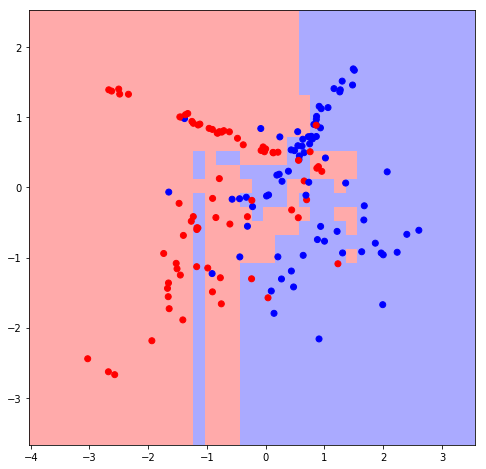

In [14]:
from lightgbm import LGBMClassifier

clf = LGBMClassifier(n_estimators=300)
clf.fit(X_train, y_train)
plot_surface(X_test, y_test, clf)

print(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

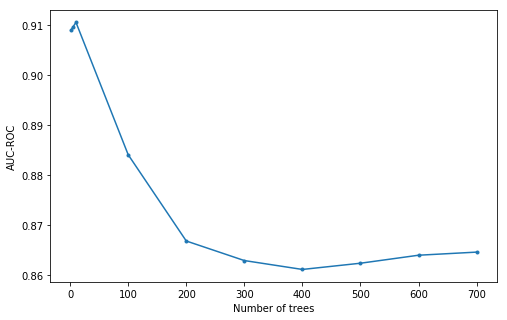

In [15]:
n_trees = [1, 5, 10, 100, 200, 300, 400, 500, 600, 700]
quals = []
for n in n_trees:
    clf = LGBMClassifier(n_estimators=n)
    clf.fit(X_train, y_train)
    q = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    quals.append(q)
    
plt.figure(figsize=(8, 5))
plt.plot(n_trees, quals, marker='.')
plt.xlabel('Number of trees')
plt.ylabel('AUC-ROC')
plt.show()

Видно, что мы начинаем быстро переобучаться. Попробуем зафиксировать глубину деревьев.

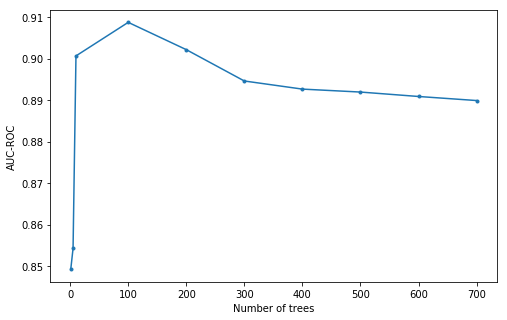

In [16]:
n_trees = [1, 5, 10, 100, 200, 300, 400, 500, 600, 700]
quals = []
for n in n_trees:
    clf = LGBMClassifier(n_estimators=n, max_depth=2)
    clf.fit(X_train, y_train)
    q = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    quals.append(q)
    
plt.figure(figsize=(8, 5))
plt.plot(n_trees, quals, marker='.')
plt.xlabel('Number of trees')
plt.ylabel('AUC-ROC')
plt.show()

Напоследок можно посмотреть [визуализацию](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html) градиентного бустинга для решающих деревьев различной глубины для функций различного вида.